# Zadanie 3 (7 punktów)

Celem ćwiczenia jest imlementacja metody [Minimax z obcinaniem alpha-beta](https://en.wikipedia.org/wiki/Alpha%E2%80%93beta_pruning) do gry  Czwórki (ang. Connect Four).

W trakcie ćwiczenia można skorzystać z reposytorium z implementacją gry [Connect Four udostępnionym przez Jakuba Łyskawę](https://github.com/lychanl/two-player-games). Ewentualnie, można zaimplementować samemu grę Connect Four.

Należy zaimplementować co najmniej dwie heurystyki do ewaluacji planszy.  

Implementację algorytmu Minimax (klasa `MiniMaxSolver`) należy przetestować używając różną głębokość przeszukiwania symulując grę "komputer vs komputer". W eksperymentach należy również zademonstrować różnice pomiędzy heurystykami.  

W ramach zadania można zaimplementować dowolną liczbę dodatkowych metod w klasie `MiniMaxSolver`.

Punktacja:

- Działająca metoda Minimax oraz heurystyki do ewaluacji planszy. - **2 pkt**
- Działająca metoda Minimax z obcinaniem alpha-beta. - **1.5 pkt**
- Analiza jakości solvera w zależności od głębokości przeszukiwania - wykresy. - **2pkt**
    - należy zaimplementować w tym celu prostą wizualizację rozgrywki dwóch agentów
- Jakość kodu. - **1.5pkt**

Aby importowanie elementów z poniższej komórki działało należy umieścić tego notebooka w tym samym folderze co paczkę `two_player_games`:
```
├── LICENSE
├── README.md
├── minimax.ipynb # <<< HERE
├── test
│   ├── __init__.py
│   ├── test_connect_four.py
│   ├── test_dots_and_boxes.py
│   └── test_pick.py
└── two_player_games
    ├── __init__.py
    ├── games
    │   ├── connect_four.py
    │   └── dots_and_boxes.py
    ├── move.py
    ├── player.py
    └── state.py
```

In [2]:
from typing import Tuple, List, Callable

from two_player_games.player import Player
from two_player_games.games.connect_four import ConnectFour, ConnectFourMove, ConnectFourState
import random

Wielkość planszy

In [3]:
ROW_COUNT = 6
COLUMN_COUNT = 7

In [4]:
class MinMaxSolver:

    def __init__(self, game: ConnectFour, heuristic_function: Callable[[ConnectFourState, Player, Player], float]):
        self.game = game
        self.heuristic = heuristic_function

    def get_best_move(self, depth_max, depth_min)->int:
        is_maximizing = self.game.first_player.char == self.game.get_current_player().char
        depth = depth_max if is_maximizing else depth_min
        result, _ = self.minimax(depth, float("-inf"), float("inf"), is_maximizing, self.game.state)
        return result

    def is_valid_move(self, col_index:int, position: ConnectFourState)->bool:
        return position.fields[col_index].count(None) > 0

    def eval_position(self, position: ConnectFourState) -> float:
        return self.heuristic(position, self.game.first_player, self.game.second_player)

    def minimax(self, depth, alpha:float, beta:float, is_maximizing_player:bool, position: ConnectFourState)-> Tuple[int, float]:
        """Returns column index and score"""
        if depth == 0 or position.is_finished():
            return None, self.eval_position(position)

        column = 0
        col_indexes = list(range(COLUMN_COUNT))
        random.shuffle(col_indexes)
        if is_maximizing_player:
            max_eval = float("-inf")
            for col in col_indexes:
                if not self.is_valid_move(col, position):
                    continue
                child = ConnectFourMove(col)
                new_position = position.make_move(child)
                _, eval = self.minimax(depth - 1, alpha, beta, False, new_position)
                if max_eval < eval:
                    max_eval = eval
                    column = col
                alpha = max(max_eval, alpha)
                if alpha >= beta:
                    break
            return column, max_eval
        else:
            min_eval = float("inf")
            for col in col_indexes:
                if not self.is_valid_move(col, position):
                    continue
                child = ConnectFourMove(col)
                new_position = position.make_move(child)
                _, eval = self.minimax(depth - 1, alpha, beta, True, new_position)
                if min_eval > eval:
                    min_eval = eval
                    column = col
                beta = min(beta, min_eval)
                if alpha >= beta:
                    break

            return column, min_eval


### Heurystyki

In [5]:
from typing import Optional

def first_heuristic(state: ConnectFourState, max_player:Player, min_player:Player):

    if state.is_finished():
        if state.get_winner() == max_player:
            return 999999999
        elif state.get_winner() == min_player:
            return -999999999
        else:
            return 0

    def score_line(line, player: Player) -> int:
        line = list(map(lambda x: x.char if x is not None else None, line))
        score = 0
        streak_count = line.count(player.char)
        empty_count = line.count(None)

        if streak_count == 4:  # Winning streak
            score += 10000000
        elif streak_count == 3 and empty_count == 1:  # Potential winning move
            score += 10000
        elif streak_count == 2 and empty_count == 2:  # Building streak
            score += 10

        return score

    fields = state.fields

    lines = []
    # Vertical
    for column_id in range(COLUMN_COUNT):
        for start_row_id in range(ROW_COUNT - 3):
            lines.append([fields[column_id][start_row_id + i] for i in range(4)])

    # Horizontal
    for start_column_id in range(COLUMN_COUNT - 3):
        for row_id in range(ROW_COUNT):
            lines.append([fields[start_column_id + i][row_id] for i in range(4)])


    # Diagonal
    for start_column_id in range(COLUMN_COUNT - 3):
        for start_row_id in range(ROW_COUNT - 3):
            lines.append([fields[start_column_id + i][start_row_id + i] for i in range(4)])
            lines.append([fields[start_column_id - i + 3][start_row_id + i] for i in range(4)])

    result = 0
    for line in lines:
        result += score_line(line, max_player)
        result -= score_line(line, min_player)

    return result

def second_heuristic(state: ConnectFourState, max_player:Player, min_player:Player):

    if state.is_finished():
        if state.get_winner() == max_player:
            return 999999999
        elif state.get_winner() == min_player:
            return -999999999
        else:
            return 0


    weights = [
    [3, 4, 5, 5, 4, 3],
    [4, 6, 8, 8, 6, 4],
    [5, 8, 11, 11, 8, 5],
    [7, 10, 13, 13, 10, 7],
    [5, 8, 11, 11, 8, 5],
    [4, 6, 8, 8, 6, 4],
    [3, 4, 5, 5, 4, 3]
    ]



    result = 0
    for col in range(COLUMN_COUNT):
        for row in range(ROW_COUNT):
            weight = weights[col][row]
            if state.fields[col][row] is not None:
                result += weight if state.fields[col][row] == max_player else -weight
    return result


### Kod do przedstawienia wynikow

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def play(depth_max, depth_min, heuristic_func, player_max=Player('a'), player_min=Player('b'), verbose=False):
    game = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=player_max, second_player=player_min)
    minimax = MinMaxSolver(game, heuristic_func)
    while(not game.is_finished()):
        move = minimax.get_best_move(depth_max, depth_min)
        game.make_move(ConnectFourMove(move))
        if verbose:
            print(game, "\n-------------------------------------------")
    if verbose:
        if game.get_winner() is not None:
            print("Winner: ", game.get_winner().char)
        else:
            print("Tie")
    return game.get_winner()

def simulate(iterations, depth_max, depth_min, heuristic_func):
    winners = {'a': 0, 'b': 0, 'tie': 0}
    p1 = Player("a")
    p2 = Player("b")
    for i in range(iterations):
        winner = play(depth_max, depth_min, heuristic_func, player_max=p1, player_min=p2)
        if winner is not None:
            winners[winner.char] += 1
        else:
            winners['tie'] += 1
    return winners

def plot_three_bars(depths_max, depths_min, heuristic_func, iterations, title):
    max_winners = []
    min_winners = []
    ties = []
    if len(depths_max) != len(depths_min):
        return

    for i in range(len(depths_min)):
        out = simulate(iterations, depths_max[i], depths_min[i], heuristic_func)
        max_winners.append(out['a'])
        min_winners.append(out['b'])
        ties.append(out['tie'])

    bar_width = 0.25
    x = np.arange(len(depths_min))

    plt.bar(x - bar_width, max_winners, width=bar_width, label='max player', color='blue')
    plt.bar(x, min_winners, width=bar_width, label='min player', color='green')
    plt.bar(x + bar_width, ties, width=bar_width, label='tie', color='red')

    categories = [f'{depths_max[i]} {depths_min[i]}' for i in range(len(depths_min))]

    plt.xlabel('depth_max depth_min')
    plt.ylabel('Values')
    plt.title(title)
    plt.xticks(x, categories)  # Set x-axis tick labels to category names
    plt.legend()               # Add a legend
    plt.tight_layout()         # Adjust layout for better fit

    plt.show()



## Przykładowa gra 

In [7]:
play(4, 4, second_heuristic, verbose=True)

Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ] 
-------------------------------------------
Current player: a
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ] 
-------------------------------------------
Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ] 
-------------------------------------------
Current player: a
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ] 
-------------------------------------------
Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ] 
-------------------------------------------
Current player: a
[ ][ ][

## Symulacje dla tych samych głębokości

In [ ]:
plot_three_bars([i+1 for i in range(4)], [i+1 for i in range(4)], first_heuristic, 50, "Pierwsza heurystyka")
plot_three_bars([i+1 for i in range(4)], [i+1 for i in range(4)], second_heuristic, 50, "Druga Heurystyka")

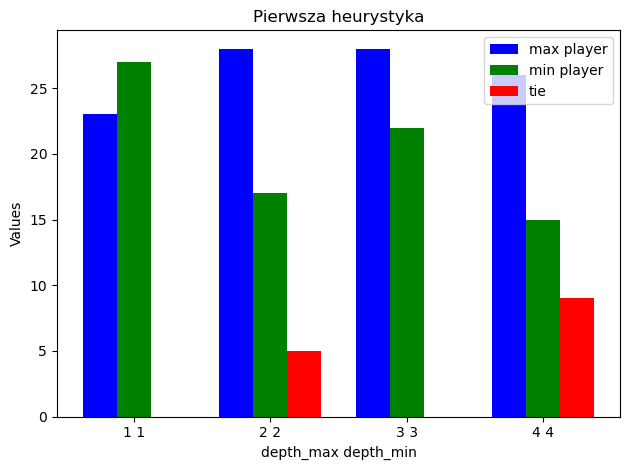
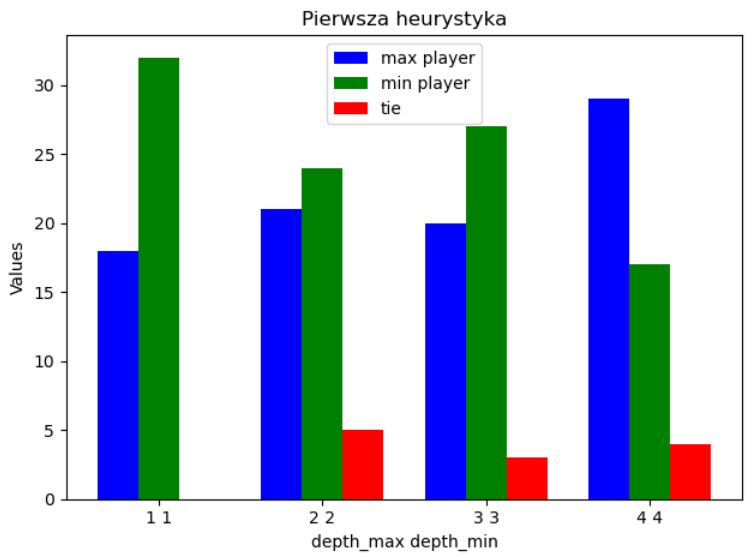

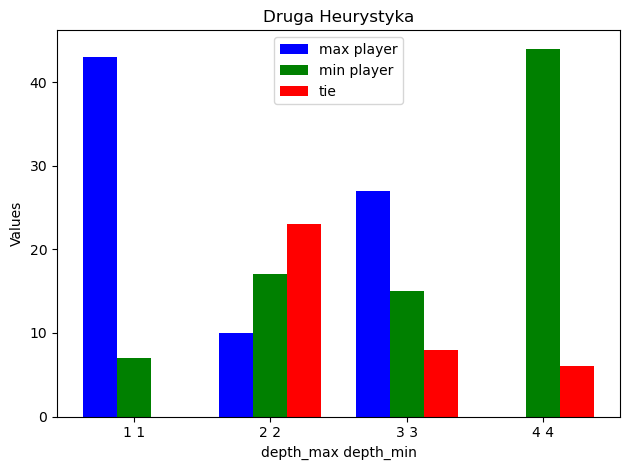

## Symulacje dla różnych głębokości


In [ ]:

plot_three_bars([1 for i in range(4)], [i+1 for i in range(4)], first_heuristic, 50, "Pierwsza heurystyka")
plot_three_bars([1 for i in range(4)], [i+1 for i in range(4)], second_heuristic, 50, "Druga Heurystyka")

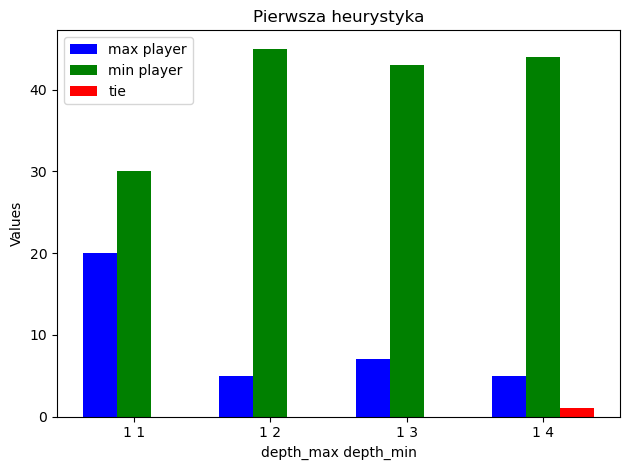
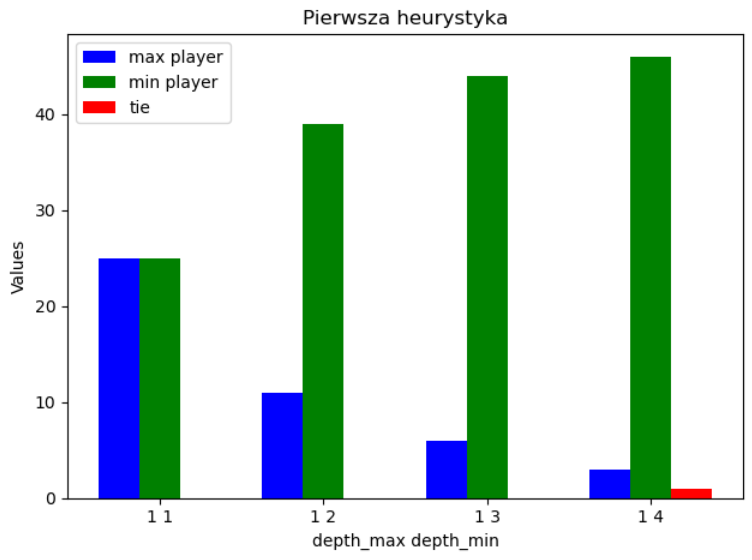

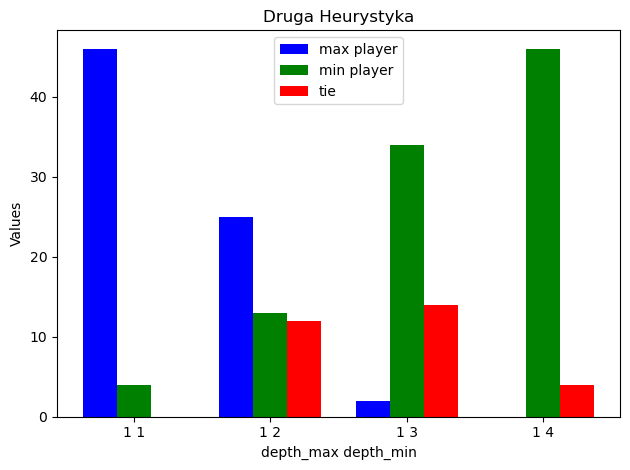
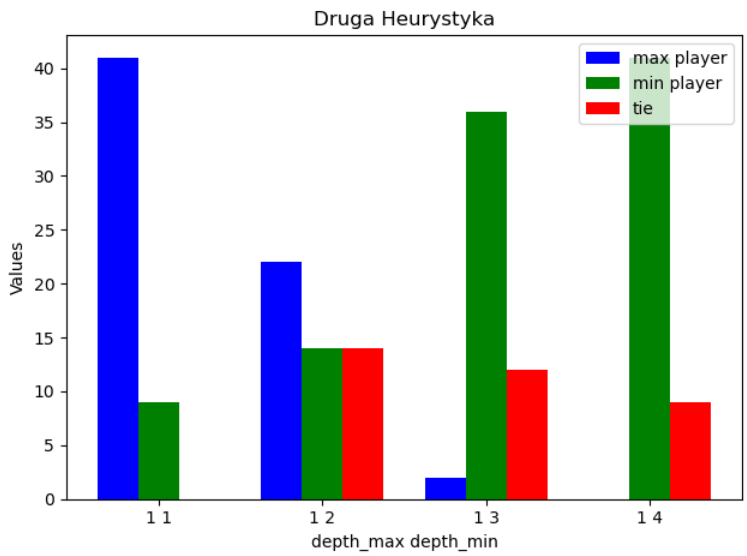

##  Wnioski
Głębokość przeszukiwania jest określa 'poziom umiejętności komputera'
im głębsze jest przeszukiwanie tym komputer potrafi lepiej określić
najbardziej optymalny ruch. Dla przykładu, kiedy jeden z komputerów
grających na siebie miał głębokość 1 a drugi kolejno 1, 2, ...
to ten drugi wygrywał większość gier gdy jego głębokośc się zwiększała

W zależności od użytej heurystyki wyniki mogą drastycznie się różnić